### Check boundary conditions for present day experiment (B-SOSE)

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import glob
import gsw
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.file_io import read_woa
from nemo_python_git.interpolation import regrid_operator_cf, regrid_array_cf
from nemo_python_git.utils import convert_to_teos10

In [142]:
#  File locations on laptop:
folder_base = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
files_BC    = glob.glob(f'{folder_base}boundary-conditions/B-SOSE/SOSE-THETA-boundary-conditions-20240807_m??.nc')
SOSE_BCs    = xr.open_mfdataset(files_BC, concat_dim='t', combine='nested').mean(dim='t').isel(time_counter=0,y=0)
WOA_ds      = xr.open_mfdataset([f'{folder_base}WOA18/woa18_decav_t00_04.nc',f'{folder_base}WOA18/woa18_decav_s00_04.nc'],
                                decode_times=False).isel(time=0, lat=slice(158,160))
NEMO_mesh   = xr.open_dataset(f'{folder_base}bathymetry/mesh_mask-20240305.nc').isel(time_counter=0)

In [145]:
WOA_ds_temp = convert_to_teos10(WOA_ds.rename({'t_an':'InsituTemp','s_an':'PracSal'}), var='InsituTemp')

In [146]:
WOA_ds['t_an'] = WOA_ds_temp
WOA_source = WOA_ds.rename({'t_an':'data', 'lon':'x', 'lat':'y', 'depth':'z'})
longrid, latgrid = np.meshgrid(WOA_source.x, WOA_source.y)
WOA_source = WOA_source.assign({'depth':WOA_source.z, 'lon':(('y','x'), longrid), 'lat':(('y','x'), latgrid)})
nemo_dest  = NEMO_mesh.rename({'nav_lon':'lon', 'nav_lat':'lat', 'nav_lev':'z', 'gdept_0':'depth'}).isel(y=slice(-10,None))

# rgo = regrid_operator_cf(WOA_source, nemo_dest, key_3d=True, method='linear', src_cyclic=True, dst_cyclic=True)
ds  = regrid_array_cf(WOA_source, rgo, key_3d=True, method='linear', src_cyclic=True, dst_cyclic=True)

In [147]:
WOA_interp = nemo_dest.assign({'ConsTemp':(('z','y','x'), ds.array)})

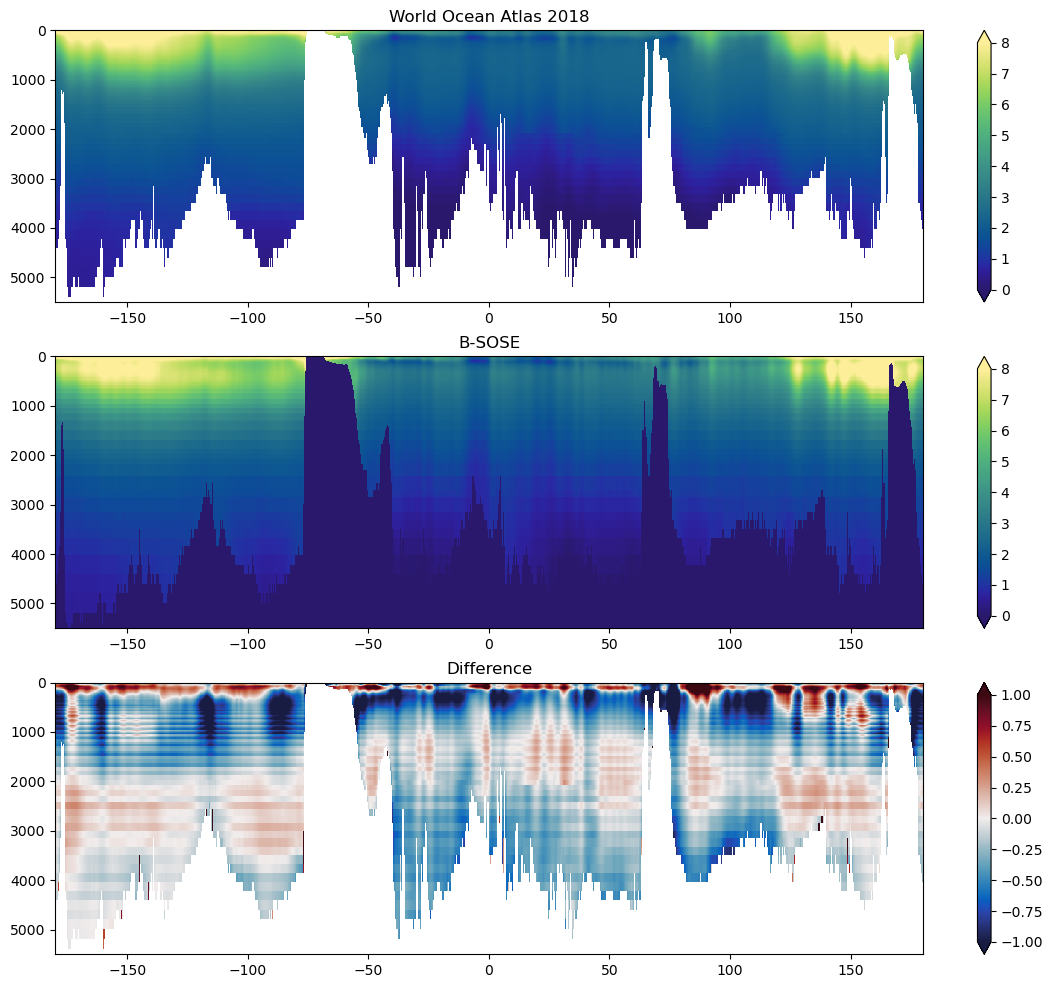

In [149]:
fig, ax = plt.subplots(3,1, figsize=(14,12))

kwags={'vmin':0, 'vmax':8, 'cmap':cmocean.cm.haline}
c1 = ax[0].pcolormesh(WOA_interp.isel(y=-2).sortby('lon').lon, WOA_interp.z, WOA_interp.isel(y=-2).sortby('lon').ConsTemp, **kwags)
c2 = ax[1].pcolormesh(SOSE_BCs.sortby('x').x, NEMO_mesh.nav_lev, SOSE_BCs.sortby('x').PotTemp, **kwags)
c3 = ax[2].pcolormesh(SOSE_BCs.sortby('x').x, NEMO_mesh.nav_lev, 
                      (WOA_interp.isel(y=-2).sortby('lon').ConsTemp.values - SOSE_BCs.sortby('x').PotTemp.values),
                      vmin=-1,vmax=1, cmap=cmocean.cm.balance)

ax[0].set_title('World Ocean Atlas 2018')
ax[1].set_title('B-SOSE')
ax[2].set_title('Difference')

cbar = [c1,c2,c3]
for n,axis in enumerate(ax.ravel()):
    axis.set_ylim(5500, 0)
    plt.colorbar(cbar[n], ax=ax[n], extend='both')